In [1]:
import pandas as pd
import os
import sys
from skimage import io, exposure, transform
import cv2 as cv
import yaml
import tensorflow as tf
import numpy as np
import scipy.io as sio
from PIL import Image
sys.path.append("../")
from Fast_RCNN.rpn_proposal.utils import  generate_anchors, pre_process_xml, read_data, resize_img_bbox
from Fast_RCNN.unified_network.networks import unified_net
from Fast_RCNN.unified_network.ops import offset2bbox, non_max_suppression
from utils import load_images_and_labels
import xml.etree.ElementTree as ET
import yaml
import seaborn as sns
import random
import warnings
import time
tf.set_random_seed(0)
np.random.seed(0)
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
main_dir = '/ocean/projects/asc170022p/singla/ExplainingBBSmoothly'

# Config

In [3]:
main_dir = '/ocean/projects/asc170022p/singla/ExplainingBBSmoothly'
# config_file = 'configs/Step_3_MIMIC_Object_Detector_256_Costophrenic_Recess.yaml'
config_file = 'configs/Step_3_MIMIC_Object_Detector_256_Pacemaker.yaml'
config_path = os.path.join(main_dir, config_file)
config = yaml.load(open(config_path))

In [4]:
config

{'BATCHSIZE': 2,
 'CLASSES': ['pacemaker'],
 'CROP': False,
 'EPSILON': '1e-10',
 'IMG_H': 256,
 'IMG_PATH': '/ocean/projects/asc170022p/singla/CSV_MIMIC/ObjectDetector_PA/pacemaker/img/',
 'IMG_W': 256,
 'LEARNING_RATE': 0.001,
 'MINIBATCH': 64,
 'MOMENTUM': 0.9,
 'NMS_THRESHOLD': 0.7,
 'NUMS_PROPOSAL': 2000,
 'POOLED_H': 7,
 'POOLED_W': 7,
 'SUFFIX': '.jpeg',
 'WEIGHT_DECAY': 0.0005,
 'XML_PATH': '/ocean/projects/asc170022p/singla/CSV_MIMIC/ObjectDetector_PA/pacemaker/xml/',
 'ckpt_dir_continue': 'output/ObjectDetector/pacemaker',
 'image_dir': '',
 'log_dir': 'output/ObjectDetector',
 'name': 'pacemaker',
 'num_channel': 1,
 'starting_step': 1,
 'vgg_checkpoint': 'output/classifier/StanfordCheXpert_256_VGG/cp_epoch0.ckpt'}

In [17]:
# config['ckpt_dir_continue'] = 'output/ObjectDetector/costophrenic'
# config['name'] = 'costophrenic'

# Load Object Detector Model

In [5]:
# ============= Experiment Parameters =============
name = config['name']
batch_size = 1 #config['BATCHSIZE']
channels = config['num_channel']
IMG_H = config['IMG_H'] 
IMG_W = config['IMG_W'] 
MINIBATCH = 256 #config['MINIBATCH'] 
NUMS_PROPOSAL = 300 #config['NUMS_PROPOSAL'] 
NMS_THRESHOLD = 0.7 #config['NMS_THRESHOLD'] 
XML_PATH = config['XML_PATH']
IMG_PATH = config['IMG_PATH']
CLASSES = config['CLASSES']

In [6]:
anchors = generate_anchors(IMG_H, IMG_W)

imgs = tf.placeholder(tf.float32, [None, IMG_H, IMG_W, 1])
cls, reg, proposal, vgg_logits = unified_net(imgs, anchors, CLASSES,  NUMS_PROPOSAL, NMS_THRESHOLD, IMG_H, IMG_W)

x0, y0, x1, y1 = proposal[:, 0:1], proposal[:, 1:2], proposal[:, 2:3], proposal[:, 3:4]
x, y, w, h = (x0 + x1) / 2, (y0 + y1) / 2, x1 - x0, y1 - y0
proposal = tf.concat([x, y, w, h], axis=1)
normal_bbox, reverse_bbox = offset2bbox(reg, proposal)
cls = tf.nn.softmax(cls)
boxes, score, classes = non_max_suppression(cls, reverse_bbox,  CLASSES)

('inputs: ', <tf.Tensor 'vgg_16/conv5/conv5_3/Relu:0' shape=(?, 16, 16, 512) dtype=float32>)


('rpn_cls: ', <tf.Tensor 'Reshape:0' shape=(?, ?, 2) dtype=float32>)
('normal_bbox: ', <tf.Tensor 'embedding_lookup_1/Identity:0' shape=(?, 4) dtype=float32>)
('reverse_bbox: ', <tf.Tensor 'div_4:0' shape=(?, 4) dtype=float32>)
('bbox_idx: ', <tf.Tensor 'zeros:0' shape=(300,) dtype=int32>)
Instructions for updating:
box_ind is deprecated, use box_indices instead
('inputs: ', <tf.Tensor 'vgg_16_1/dropout7/dropout/mul_1:0' shape=(300, 1, 1, 4096) dtype=float32>)
('inputs: ', <tf.Tensor 'Squeeze:0' shape=(300, 4096) dtype=float32>)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
assets_dir = os.path.join(main_dir, config['log_dir'], config['name'])
ckpt_dir = os.path.join(assets_dir, 'ckpt_dir')
ckpt_dir

'/ocean/projects/asc170022p/singla/ExplainingBBSmoothly/output/ObjectDetector/pacemaker/ckpt_dir'

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
fast_rcnn_var = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="vgg_16") + \
                tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="classification") + \
                tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="regression")
rpn_var = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="rpn")
saver = tf.train.Saver(fast_rcnn_var)
saver.restore(sess, os.path.join(ckpt_dir,"model_frcnn_step6_"+config['name']+".ckpt"))
print("Fast RCNN Check point restored", os.path.join(ckpt_dir,"model_frcnn_step6_"+config['name']+".ckpt"))
print("Done.......")
saver = tf.train.Saver(rpn_var)
saver.restore(sess, os.path.join(ckpt_dir,"model_rpn_step4_"+config['name']+".ckpt"))
print("Model RPN Check point restored", os.path.join(ckpt_dir,"model_rpn_step4_"+config['name']+".ckpt"))
print("Done.......")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /ocean/projects/asc170022p/singla/ExplainingBBSmoothly/output/ObjectDetector/pacemaker/ckpt_dir/model_frcnn_step6_pacemaker.ckpt
('Fast RCNN Check point restored', '/ocean/projects/asc170022p/singla/ExplainingBBSmoothly/output/ObjectDetector/pacemaker/ckpt_dir/model_frcnn_step6_pacemaker.ckpt')
Done.......
INFO:tensorflow:Restoring parameters from /ocean/projects/asc170022p/singla/ExplainingBBSmoothly/output/ObjectDetector/pacemaker/ckpt_dir/model_rpn_step4_pacemaker.ckpt
('Model RPN Check point restored', '/ocean/projects/asc170022p/singla/ExplainingBBSmoothly/output/ObjectDetector/pacemaker/ckpt_dir/model_rpn_step4_pacemaker.ckpt')
Done.......


# Visualize Results

In [9]:
colors = ['r', 'b', 'g', 'k']
label = ''
for i in range(len(config['CLASSES'])):
    label += colors[i] + ': ' + config['CLASSES'][i] + ' '

## Costophrenic Recess

In [22]:
# read some random images

real_img = np.load(os.path.join(main_dir, 'output/classifier/StanfordCheXpert_256', 
                                'Explainer_MIMIC_Pleural_Effusion', 'test','real_img_train_set.npy'))
print(real_img.shape)

(484, 256, 256, 1)


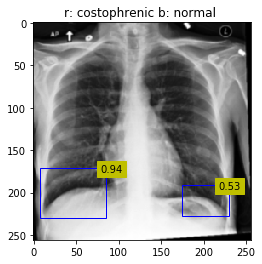

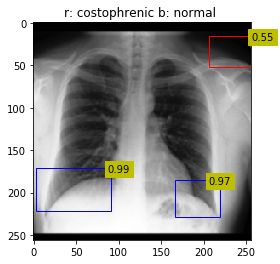

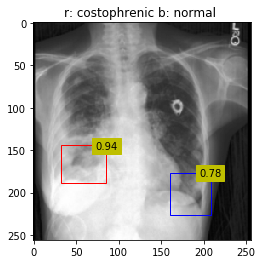

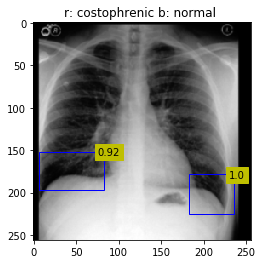

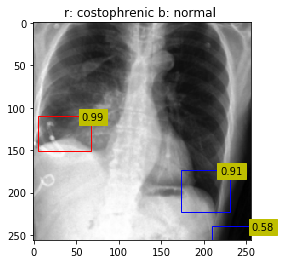

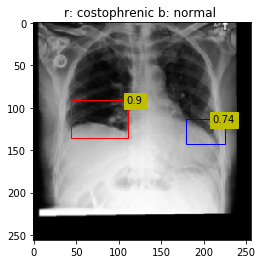

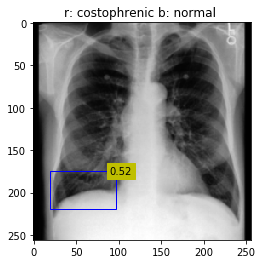

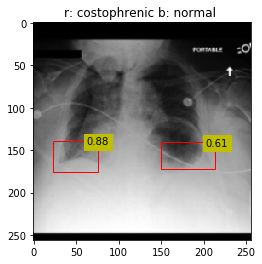

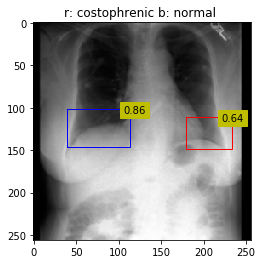

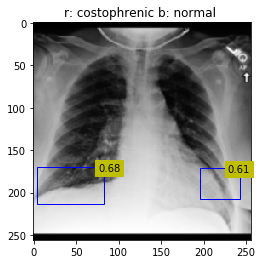

In [37]:
for i in range(0, 10):
    img = real_img[i,:,:,:]
    img = np.expand_dims(img,0)
    _cls = sess.run([cls, reg, proposal],feed_dict={imgs: img})
    [BBOX, SCORE, CLS] = sess.run([boxes, score, classes], feed_dict={imgs: img})
    CLS = CLS.astype(int)
    SCORE = np.round(SCORE,2)
    fig,ax = plt.subplots(1)
    ax.imshow(img[0,:,:,0],cmap='gray')
    for i in range(BBOX.shape[0]):
        X0, Y0, X1, Y1 = BBOX[i, 0:1], BBOX[i, 1:2], BBOX[i, 2:3], BBOX[i, 3:4]
        X, Y, W, H = X0 , Y0, X1 - X0, Y1 - Y0
        if X[0]<0 or Y[0]<0:
            continue
        BBOX1 = np.concatenate((X, Y, W, H), axis=-1)
        area = H*W
        if area > 9999:
            continue 
        ax.set_title(label)
        
        rect1 = patches.Rectangle((X,Y),W,H,linewidth=1,edgecolor=colors[CLS[i]],facecolor='none')
        
        ax.add_patch(rect1)
        cord_x = X[0] + W[0]+W[0]/4
        ax.text(cord_x, Y[0]-5, str(SCORE[i]), size=10, rotation=0,
                     ha="right", va="top",
                     bbox=dict(boxstyle="square",
                               ec='y',
                               fc='y',))
    plt.show()
    
   

## Pacemaker

In [23]:
# read some random images
import imageio
from PIL import Image
sample_img = os.listdir(config['IMG_PATH'])
counter = 0
for img in sample_img:
    file_name = os.path.join(config['IMG_PATH'], img)
    img = imageio.imread(file_name)
    img = np.array(Image.fromarray(img).resize([IMG_H, IMG_W]))
    img = np.reshape(img, [1,IMG_H,IMG_W,channels])
    _cls = sess.run([cls, reg, proposal],feed_dict={imgs: img})
    [BBOX, SCORE, CLS] = sess.run([boxes, score, classes], feed_dict={imgs: img})
    if BBOX.shape[0] !=0:
        CLS = CLS.astype(int)
        SCORE = np.round(SCORE,2)
        fig,ax = plt.subplots(1)
        ax.imshow(img[0,:,:,0],cmap='gray')
        for i in range(BBOX.shape[0]):
            X0, Y0, X1, Y1 = BBOX[i, 0:1], BBOX[i, 1:2], BBOX[i, 2:3], BBOX[i, 3:4]
            X, Y, W, H = X0 , Y0, X1 - X0, Y1 - Y0
            if X[0]<0 or Y[0]<0:
                continue
            BBOX1 = np.concatenate((X, Y, W, H), axis=-1)
            area = H*W
            if area > 9999:
                continue 
            ax.set_title(label)

            rect1 = patches.Rectangle((X,Y),W,H,linewidth=1,edgecolor=colors[CLS[i]],facecolor='none')

            ax.add_patch(rect1)
            cord_x = X[0] + W[0]+W[0]/4
            ax.text(cord_x, Y[0]-5, str(SCORE[i]), size=10, rotation=0,
                         ha="right", va="top",
                         bbox=dict(boxstyle="square",
                                   ec='y',
                                   fc='y',))
        plt.show()
    else:
        print(counter)
        counter+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


KeyboardInterrupt: 

In [21]:
BBOX

array([], shape=(0, 4), dtype=float32)